## Visualize Training

path ferrygym ['/workspace/', '/workspace/results/1-11-vae-mix', '/usr/local/lib/python39.zip', '/usr/local/lib/python3.9', '/usr/local/lib/python3.9/lib-dynload', '', '/root/.local/share/virtualenvs/workspace-dqq3IVyd/lib/python3.9/site-packages', '/workspace']


/workspace/utils.py:139: DeprecationWarning: invalid escape sequence \d
  car_id = int(re.findall('car(\d+).pkl', splits[-1])[0])
/root/.local/share/virtualenvs/workspace-dqq3IVyd/lib/python3.9/site-packages/torch/utils/tensorboard/__init__.py:4: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if not hasattr(tensorboard, "__version__") or LooseVersion(
/root/.local/share/virtualenvs/workspace-dqq3IVyd/lib/python3.9/site-packages/gym/spaces/box.py:128: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")
/root/.local/share/virtualenvs/workspace-dqq3IVyd/lib/python3.9/site-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2894.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


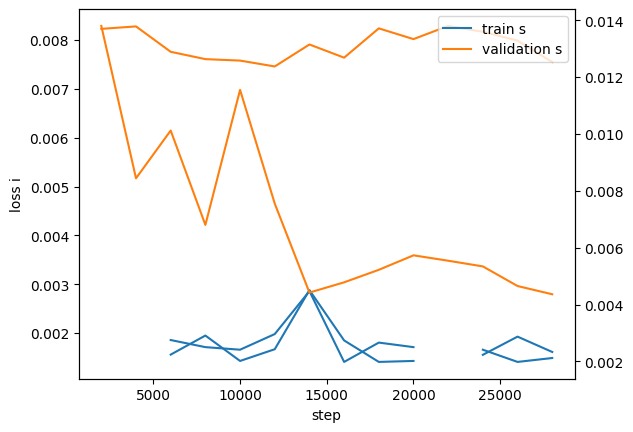

In [1]:
import re
import sys 
sys.path.insert(0, '/workspace/')
import results.utils
%matplotlib inline
import utils

path = '/workspace/results/1-11-vae-mix/model=fwd-cnn-vae-fp-layers=3-bsize=8-ncond=10-npred=20-lrt=0.0001-nfeature=256-dropout=0.1-nz=32-beta=1e-06-zdropout=0.5-gclip=5.0-warmstart=1-seed=1.log'
result = results.utils.load_log_file(path)

results.utils.plot_losses(result)


In [2]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=1
import torch
# set gpu
# torch.cuda.set_device(2)
# load model
import sys

ncond = 10
npred = 20
bsize = 16

model = torch.load('/workspace/results/1-11-vae-mix/model=fwd-cnn-vae-fp-layers=3-bsize=8-ncond=10-npred=20-lrt=0.0001-nfeature=256-dropout=0.1-nz=32-beta=1e-06-zdropout=0.5-gclip=5.0-warmstart=1-seed=1.step100000.model')

model.eval()
model.cuda()


env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=1


FwdCNN_VAE(
  (encoder): encoder(
    (f_encoder): Sequential(
      (0): Conv2d(30, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): Dropout2d(p=0.1, inplace=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
      (3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (4): Dropout2d(p=0.1, inplace=True)
      (5): LeakyReLU(negative_slope=0.2, inplace=True)
      (6): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    )
    (s_encoder): Sequential(
      (0): Linear(in_features=40, out_features=256, bias=True)
      (1): Dropout(p=0.1, inplace=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
      (3): Linear(in_features=256, out_features=256, bias=True)
      (4): Dropout(p=0.1, inplace=True)
      (5): LeakyReLU(negative_slope=0.2, inplace=True)
      (6): Linear(in_features=256, out_features=36864, bias=True)
    )
  )
  (decoder): decoder(
    (f_decoder): Sequential(
      (0): ConvTranspose2d(256

In [3]:

# get batch from dataset
from dataloader import DataLoader
class DataSettings:
        debug = False
        batch_size = bsize
        npred = npred
        ncond = ncond
        width = 100
        height = 100

    # Instantiate data set object
d = DataLoader(opt=DataSettings, data_dir='/workspace/data/rev-moenk2/training/', dataframe='df_2022-04-01 12:00:01.pkl' )
model.stats = d.get_stats()



/workspace/dataloader.py:33: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  self.df = self.df.groupby('mmsi').apply(lambda x: x.assign(group_index = range(len(x))))


Number of episodes: 336531
[loading data splits: /workspace/data/rev-moenk2/training//splits.pth]


[1042.2377    1004.42377      4.2692494  310.6275   ]


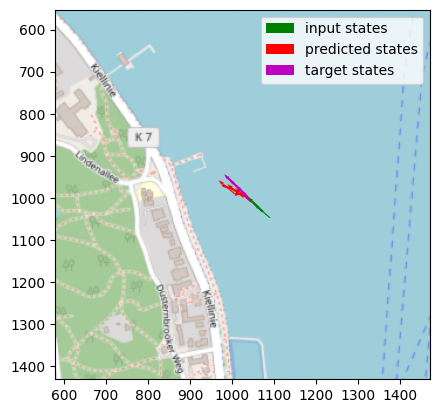

In [6]:
%matplotlib inline
inputs, actions, targets = d.get_batch_fm('valid', npred, cuda=True, onlyMoving=True, onlyTurning=True, onlyOtherShips=True)
preds, loss_p = model(inputs, actions, targets, z_dropout=0.5)
sample = 1
utils.plot_denormalized_states(model.stats, inputs, targets, preds, sample)

In [15]:
inputs, actions, targets = d.get_batch_fm('valid', npred, cuda=True, onlyMoving=True, onlyTurning=False)

In [6]:
# save batch
# utils.save_batch(inputs, actions, targets, preds, model.stats, 0, '/workspace/results/20-10-syntetic/going-south-working2.pth')
# load batch
inputs, actions, targets = utils.load_batch('/workspace/results/20-10-syntetic/going-south-working.pth')

In [6]:
inputs_syntetic, actions_syntetic, targets_syntetic = d.get_syntetic_batch_fm()
inputs = [inputs_syntetic[0], inputs[1]]


/workspace/dataloader.py:374: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch_actions.append(torch.tensor(action))


[1364.9247    1587.2874       4.5085588  192.75772  ]


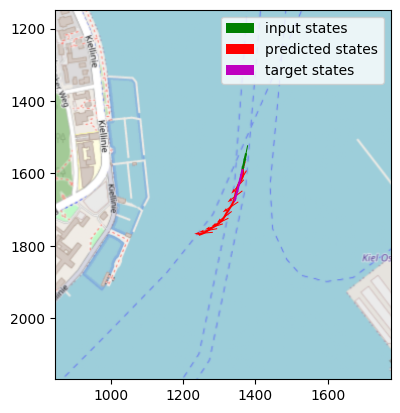

In [9]:
%matplotlib inline

import utils
number_of_predictions = 50
sample = 1
preds = utils.test_action(model, inputs, torch.Tensor([[0,
5]]).cpu(), number_of_predictions)
utils.plot_denormalized_states(model.stats, inputs, targets, preds, sample)

tensor([1271.1891, 1734.6409,    4.7984,  193.2730], dtype=torch.float64)


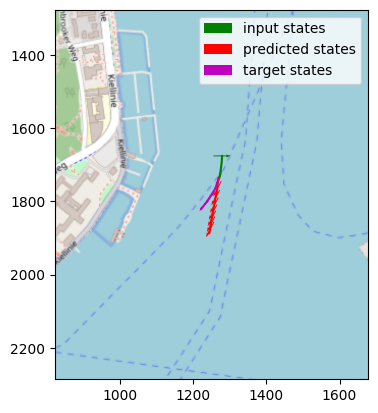

In [79]:
# save batch
# utils.save_batch(inputs, actions, targets, preds, model.stats, 3, '/workspace/results/7-10-vae/not-right.pth')
# load batch
batch = torch.load('/workspace/results/7-10-vae/not-right.pth')
utils.plot_denormalized_states(batch['stats'], batch['inputs'], batch['targets'], batch['preds'], batch['batch_no'])


In [4]:
# save batch showing other ship
# utils.save_batch(inputs, actions, targets, preds, model.stats, 2, '/workspace/results/29-10-dnn-mix/other-ship.pth')
# load batch
inputs, actions, targets = utils.load_batch('/workspace/results/29-10-dnn-mix/other-ship.pth')
sample = 2
preds, loss_p = model(inputs, actions, targets, z_dropout=0.5)

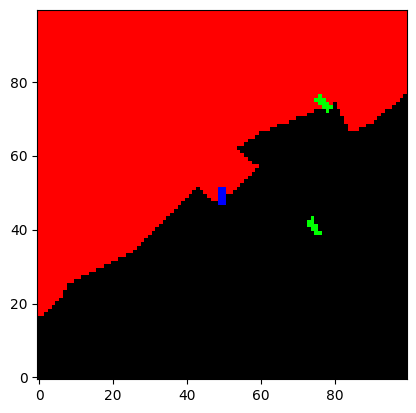

In [22]:
%matplotlib inline

results.utils.plot_image(targets[0][sample][0])


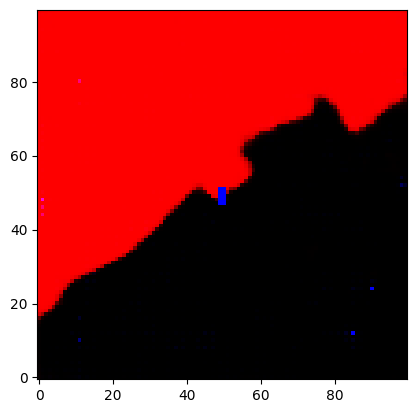

In [23]:
%matplotlib inline

results.utils.plot_image(preds[0][sample][0])
